In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import a dataset that will help us guessing a gender for each name
# Data by  Lax-Martinez, G., Raffo, J. and Saito, K. 2016. "Identifying the Gender of PCT inventors", WIPO Economic Research Working Paper 33.

additional_gender = pd.read_csv("wgnd_source.csv", encoding="utf-8")

# import data for funded profs and projects

person_data = pd.read_csv("extracted_person_data.csv", encoding = "utf-8")
pp_data = pd.read_csv("project_person_relations.csv", encoding = "utf-8")

In [5]:
# extract first names

person_data['name'] = person_data['name'].str.lower()
person_data['first_name'] = person_data['name'].str.split(' ').str[-2]

In [5]:
# sort by first name 
# data.sort_values("person_id", inplace = True)  

In [6]:
# drop duplicte values so that there's only one name per person id
# data_wo_duplicates = data.drop_duplicates(subset ="person_id", keep = 'first')

In [6]:
# prepare data: extract title so that we can make a quick validity check later

person_data['title'] = person_data['name'].str.split(' ').str[0]

# prepare data: reduce gender option to one per name

additional_gender['name'] = additional_gender['name'].str.lower()
single_gender = additional_gender.drop_duplicates(subset ="name", keep = 'first') 
single_gender = single_gender[['name', 'gender', 'code']]

In [7]:
# map gender and names
    
gender_map = single_gender.set_index('name').to_dict()['gender']  
person_data['gender'] = person_data.set_index('first_name').index.map(gender_map)   

In [9]:
# improve mapping that fails due to wrong extraction of first name

#unknown = ((data['gender'].isnull()) & (data['title']=='professor')) | ((data['gender'].isnull()) & (data['title']=='professorin'))
#unknown = data[unknown]

#unknown['first_name'] = unknown['name'].str.split(' ').str[2]
#unknown['gender'] = unknown.set_index('first_name').index.map(gender_map)   

#unknown_improved = ((unknown['gender'].isnull()) & (unknown['title']=='professor')) | ((unknown['gender'].isnull()) & (unknown['title']=='professorin'))
#unknown_still = unknown[unknown_improved]

#unknown_improvement = unknown[~unknown_improved]

In [10]:
#unknown_improvement['gender'] = unknown_improvement.set_index('first_name').index.map(gender_map)  

# TODO Only map the values when 'gender' is NaN in data
#improvement_map = unknown_improvement.set_index('person_id').to_dict()['gender']
#data['gender'] = data.set_index('person_id').index.map(improvement_map)

In [8]:
# compare title and assigned gender for profs as validation

match = ((person_data['gender']=='M') & (person_data['title']=='professor')) | ((person_data['gender']=='F') & (person_data['title']=='professorin'))
match = person_data[match]

mismatch = ((person_data['gender']=='F') & (person_data['title']=='professor')) | ((person_data['gender']=='M') & (person_data['title']=='professorin'))
mismatch = person_data[mismatch]

still_unknown = ((person_data['gender'].isnull()) & (person_data['title']=='professor')) | ((person_data['gender'].isnull()) & (person_data['title']=='professorin'))
still_unknown = person_data[still_unknown]

print(match.shape)
print(mismatch.shape)
print(still_unknown.shape)

(24939, 10)
(231, 10)
(6237, 10)


In [12]:
# improve unknown mapping

#unknown['first_name'] = unknown['name'].str.split(' ').str[2]
#unknown['gender'] = unknown.set_index('first_name').index.map(gender_map)   

In [13]:
# calculate error ratio for profs

all_cases = len(match.index) + len(mismatch.index) + len(still_unknown.index)
error_ratio = (len(mismatch.index) + len(still_unknown.index)) / all_cases * 100
error_ratio

20.594135065431274

In [14]:
# check how valid / successful is within the entire data set

print(person_data['gender'].isna().sum())
print(person_data['gender'].value_counts())
print('Fehler, mindestens:')
print((10339+981)/(10339+981+35632+10988)*100)

10339
M    35632
F    10988
?      981
Name: gender, dtype: int64
Fehler, mindestens:
19.537452537107352


In [9]:
# create smaller dataset that can be exported publicly
reduced_data = person_data[['person_id', 'name', 'first_name', 'gender']]
#reduced_data.to_csv("data/reduced_data_person.csv", encoding="utf-8")

In [10]:
# begin with calculating the gender index now
# start with sorting the projects by id for a nicer overview

pp_data.sort_values('project_id_number', inplace=True)
pp_data

,project_id_number,person_id,relation_type
0,268853,1292506,SPOKESPERSON
1,268879,1063271,SPOKESPERSON
10,268931,253719,PARTICIPATING_SCIENTIST
9,268931,253717,PARTICIPATING_SCIENTIST
8,268931,260484,PARTICIPATING_SCIENTIST
...,...,...,...
151130,407495230,1828741,HEAD
151131,407512192,270257406,APPLICANT
151132,407924429,1089483,APPLICANT
151133,408039748,1642591,APPLICANT


In [11]:
pp_data[pp_data['project_id_number'] == 5324946]

,project_id_number,person_id,relation_type
30291,5324946,5132,APPLICANT


In [12]:
# keep only projects that have more than one person involved because those are the ones where we can measure networks / collaboration

keep = pp_data[pp_data.duplicated(subset=['project_id_number'],keep=False)]

In [13]:
# check how many projects / lines were dropped in the previous step

print(pp_data.shape)
print(keep.shape)

(151135, 3)
(53553, 3)


In [14]:
# check if correct projects were dropped

keep[keep['project_id_number']== 268931]

,project_id_number,person_id,relation_type
10,268931,253719,PARTICIPATING_SCIENTIST
9,268931,253717,PARTICIPATING_SCIENTIST
8,268931,260484,PARTICIPATING_SCIENTIST
7,268931,260482,PARTICIPATING_SCIENTIST
11,268931,1661051,SPOKESPERSON
5,268931,1078832,PARTICIPATING_SCIENTIST
4,268931,1078633,PARTICIPATING_SCIENTIST
3,268931,1376585,PARTICIPATING_SCIENTIST
2,268931,253711,PARTICIPATING_SCIENTIST
6,268931,1174308,PARTICIPATING_SCIENTIST


In [15]:
# join project data with person/gender data

project_person_gender = pd.merge(keep, reduced_data, how = 'left', left_on = 'person_id', right_on = 'person_id')

In [16]:
# check if that went well

project_person_gender[project_person_gender['project_id_number'] == 268931]

,project_id_number,person_id,relation_type,name,first_name,gender
0,268931,253719,PARTICIPATING_SCIENTIST,professor dr. hans-joachim wenzel,hans-joachim,NaN
1,268931,253717,PARTICIPATING_SCIENTIST,professor dr. albrecht weber,albrecht,M
2,268931,260484,PARTICIPATING_SCIENTIST,professor dr. dietrich tränhardt,dietrich,M
3,268931,260482,PARTICIPATING_SCIENTIST,professor dr. hans-werner niemann,hans-werner,NaN
4,268931,1661051,SPOKESPERSON,professor dr. michael bommes (†),bommes,NaN
5,268931,1078832,PARTICIPATING_SCIENTIST,professor dr. siegfried greif,siegfried,M
6,268931,1078633,PARTICIPATING_SCIENTIST,professor dr. peter graf,peter,M
7,268931,1376585,PARTICIPATING_SCIENTIST,professorin dr. eva breitenbach,eva,F
8,268931,253711,PARTICIPATING_SCIENTIST,professor dr. klaus j. bade,j.,NaN
9,268931,1174308,PARTICIPATING_SCIENTIST,professor dr. utz maas,utz,M


In [17]:
# group so that we know how many men / women are involved in each project

grouped_by_project = pd.DataFrame(project_person_gender.groupby(['project_id_number', 'gender'])[['gender']].count())

In [18]:
# how many projects with more that one person are there now?

grouped_by_project.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20582 entries, (268931, F) to (405027271, M)
Data columns (total 1 columns):
gender    20582 non-null int64
dtypes: int64(1)
memory usage: 345.3+ KB


In [19]:
grouped_by_project.head()

gender
project_id_number gender        
268931            F            1
                  M            5
269007            F            3
                  M           18
269105            F            1

In [20]:
project_gender_index = pd.DataFrame(columns=['project_id', 'gender_index'])

for idx, data in grouped_by_project.groupby(level=0):
                    
    try:
        gender_index = ((data.loc[idx, 'F'][0])/((data.loc[idx, 'F'][0])+(data.loc[idx, 'M'][0])))
    except KeyError:
        try:
            data.loc[idx, 'F'][0]
            gender_index = 1 # because project is only by women
        except KeyError:
            try:
                data.loc[idx, 'M'][0]
                gender_index = 0 # because project is only by women
            except KeyError:
                try:
                    data.loc[idx, '?'][0]
                    gender_index = 0.5 # because can't be determined
                except KeyError:
                    gender_index = 'who knows'
    
    project_gender_index = project_gender_index.append({'project_id': idx, 'gender_index': gender_index}, ignore_index=True)        



In [21]:
# do i want to figure out why there were 20582 project before and now there are only 15499? Maybe because F/M are counted
project_gender_index.shape

(15498, 2)

In [22]:
project_gender_index.to_csv('data/project_gender_index.csv', encoding = 'utf-8')

In [23]:
# prepare data for further visualization

## overall gender ratio in dataset including errors
overall_gender_data = pd.DataFrame(columns = ['labels', 'data'])
male = person_data[person_data['gender']=='M'].shape[0]
female = person_data[person_data['gender']=='F'].shape[0]
unclear = person_data[person_data['gender']=='?'].shape[0]
unassigned = person_data[person_data['gender'].isnull()].shape[0]

overall_gender_data = overall_gender_data.append({'labels': 'all_male', 'data': male}, ignore_index=True)
overall_gender_data = overall_gender_data.append({'labels': 'all_female', 'data': female}, ignore_index=True)
overall_gender_data = overall_gender_data.append({'labels': 'all_unclear', 'data': unclear}, ignore_index=True)
overall_gender_data = overall_gender_data.append({'labels': 'all_unassigned', 'data': unassigned}, ignore_index=True)
overall_gender_data.set_index('labels', inplace = True)
#overall_gender_data.to_csv('data/gender_ratio_in_dataset.csv')

## prof's gender ratio in dataset including errors
prof_gender_data = pd.DataFrame(columns = ['labels', 'data'])
prof_male = person_data[(person_data['gender']=='M') & (person_data['title']=='professor')].shape[0]
prof_male_mismatch = person_data[(person_data['gender']=='M') & (person_data['title']=='professorin')].shape[0]
prof_m_unclear = person_data[(person_data['gender']=='?') & (person_data['title']=='professor')].shape[0]
prof_m_unassigned = person_data[person_data['gender'].isnull() & (person_data['title']=='professor')].shape[0]
prof_female = person_data[(person_data['gender']=='F') & (person_data['title']=='professorin')].shape[0]
prof_female_mismatch = person_data[(person_data['gender']=='F') & (person_data['title']=='professor')].shape[0]
prof_f_unclear = person_data[(person_data['gender']=='?') & (person_data['title']=='professorin')].shape[0]
prof_f_unassigned = person_data[person_data['gender'].isnull() & (person_data['title']=='professorin')].shape[0]

prof_gender_data = prof_gender_data.append({'labels': 'prof_male', 'data': prof_male}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_male_mismatch', 'data': prof_male_mismatch}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_m_unclear', 'data': prof_m_unclear}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_m_unassigned', 'data': prof_m_unassigned}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_female', 'data': prof_female}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_female_mismatch', 'data': prof_female_mismatch}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_f_unclear', 'data': prof_f_unclear}, ignore_index=True)
prof_gender_data = prof_gender_data.append({'labels': 'prof_f_unassigned', 'data': prof_f_unassigned}, ignore_index=True)
prof_gender_data.set_index('labels', inplace = True)
#prof_gender_data.to_csv('data/prof_gender_data.csv')

## ratio of single person projects and collaborations
single_person_project_or_collab = pd.DataFrame(columns = ['labels', 'data'])
all_projects = pp_data.shape[0]
collab = keep.shape[0]
single = pp_data.shape[0] - keep.shape[0]
single_person_project_or_collab = single_person_project_or_collab.append({'labels': 'all_projects', 'data': all_projects}, ignore_index=True)
single_person_project_or_collab = single_person_project_or_collab.append({'labels': 'collab', 'data': collab}, ignore_index=True)
single_person_project_or_collab = single_person_project_or_collab.append({'labels': 'single', 'data': single}, ignore_index=True)
single_person_project_or_collab.set_index('labels', inplace = True)
#single_person_project_or_collab.to_csv('data/single_person_project_or_collab.csv')

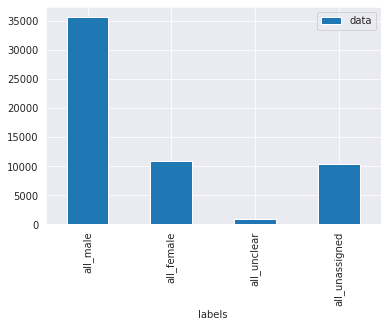

In [24]:
# quick visualizations

## Overall gender ratio within DFG
overall_gender_data.plot.bar()

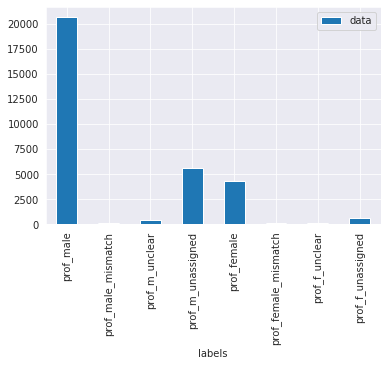

In [25]:
## Validation of gender inference

prof_gender_data.plot.bar()

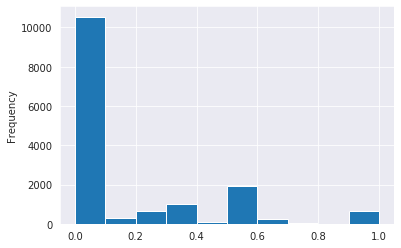

In [26]:
## Distribution of project_gender_index

project_gender_index['gender_index'].plot.hist(bins=10)

In [83]:
print(project_gender_index.groupby('gender_index').count())
print(project_gender_index.groupby('gender_index').count().sum())

              project_id
gender_index            
0.000000           10488
0.032258               1
0.041667               1
0.043478               1
0.045455               1
...                  ...
0.777778               2
0.800000               2
0.833333               1
0.857143               1
1.000000             667

[93 rows x 1 columns]
project_id    15498
dtype: int64


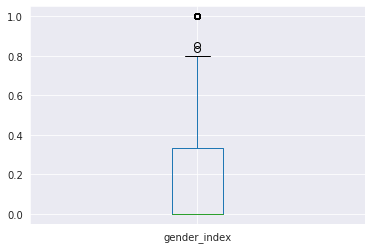

In [28]:
## Alternatively: boxplot of project_gender_index

project_gender_index['gender_index'].plot.box()

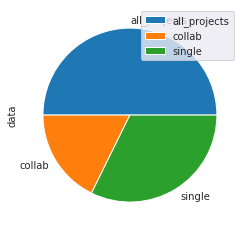

In [29]:
## Show how many projects we're dropping

single_person_project_or_collab.plot.pie(y='data')

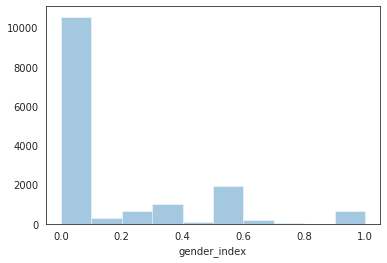

In [41]:
import seaborn as sns

sns.set_style('white')
histogram = sns.distplot(project_gender_index['gender_index'], kde=False, bins=10)



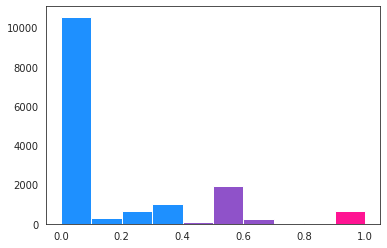

In [86]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(project_gender_index['gender_index'], 10)

for c, p in zip(bins, patches):
    if c >= 0 and c < 0.33:
        plt.setp(p, 'facecolor', 'DodgerBlue')
    elif c >= 0.33 and c < 0.66  :
        plt.setp(p, 'facecolor', '#8f52c9')
    elif c >= 0.66:
        plt.setp(p, 'facecolor', 'DeepPink')

plt.savefig("img/project_gender_index_hist.png")